## Physics Performance Notebook 
Notebook to evaluate the perfomance of full sim training. <br>
Need as imput: the training model (best_valid_model.pt) and the input graph (stored PF properties) <br>
uses pyjet to recluster the jets after we apply puppi and GNN weights


Load all needed environments

In [1]:
import argparse
import torch
from torch_geometric.data import DataLoader
#import models_ggnn_oldpipe as models
import models_fastsim as models
import utils
import matplotlib
from copy import deepcopy
import os
import copy
import uproot
import awkward as ak

#matplotlib.use("pdf")
import numpy as np
import random
import pickle
import joblib
from timeit import default_timer as timer
from tqdm import tqdm

import matplotlib as mpl
import imageio

#mpl.use("pdf")
import matplotlib.pyplot as plt
import mplhep as hep

hep.set_style(hep.style.CMS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

from pyjet import cluster, DTYPE_PTEPM
from collections import OrderedDict
import scipy.stats

True


/tmp/ipykernel_52/2404713099.py:29: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


define the deltaPhi and deltaR functions

In [2]:
def deltaPhiNew(dphis):
    dphis = np.where(dphis > np.pi, dphis - 2*np.pi, dphis)
    dphis = np.where(dphis <-np.pi, dphis + 2*np.pi, dphis)
    return dphis

def deltaRNew(detas, dphis):
    """
    calculate the deltaR based on the input deta and phi
    """
    dphis = deltaPhiNew(dphis)
    dR = np.sqrt(detas**2 + dphis**2)
    return dR

Do some preprocessings of data, needed for the model <br>
@YB: Why do we need to add the masking ??

In [3]:
def generate_mask(dataset):
    # how many LV and PU to sample
    # dataset = deepcopy(dataset_org)
    for graph in dataset:
        LV_index = graph.LV_index
        PU_index = graph.PU_index
        original_feature = graph.x[:, 0:graph.num_feature_actual]

        num_select_LV = 5
        num_select_PU = 50

        if LV_index.shape[0] < num_select_LV or PU_index.shape[0] < num_select_PU:
            num_select_LV = min(LV_index.shape[0], num_select_LV)
            num_select_PU = min(PU_index.shape[0], num_select_PU)

        # generate the index for LV and PU samples for training mask
        gen_index_LV = random.sample(range(LV_index.shape[0]), num_select_LV)
        selected_LV_train = LV_index[gen_index_LV]

        gen_index_PU = random.sample(range(PU_index.shape[0]), num_select_PU)
        selected_PU_train = PU_index[gen_index_PU]

        training_mask = np.concatenate((selected_LV_train, selected_PU_train), axis=None)
        #print(training_mask)

        # construct mask vector for training and testing
        mask_training = torch.zeros(graph.num_nodes, 1)
        mask_training[[training_mask.tolist()]] = 1

        x_concat = torch.cat((original_feature, mask_training), 1)
        graph.x = x_concat

        
        # mask the puppiWeight as default Neutral(here puppiweight is actually fromLV in ggnn dataset)
        puppiWeight_default_one_hot_training = torch.cat((torch.zeros(graph.num_nodes, 1),
                                                          torch.zeros(graph.num_nodes, 1),
                                                          torch.ones(graph.num_nodes, 1)), 1)
        puppiWeight_default_one_hot_training = puppiWeight_default_one_hot_training.type(torch.float32)
        
        #mask the pdgID for charge particles
        pdgId_one_hot_training = torch.cat((torch.zeros(graph.num_nodes, 1),
                                                          torch.zeros(graph.num_nodes, 1),
                                                          torch.ones(graph.num_nodes, 1)), 1)       
        pdgId_one_hot_training = pdgId_one_hot_training.type(torch.float32)

        #pf_dz_training_test=torch.clone(original_feature[:,6:7])
        #pf_dz_training_test = torch.zeros(graph.num_nodes, 1)    
        

        # -4 is for one hot encoding of fromLV and one mask; -1 is for final puppiweight
        #default_data_training = torch.cat(
         #   (original_feature[:, 0:(graph.num_features - 4 - 1)], puppiWeight_default_one_hot_training,
         #    original_feature[:, -1].view(-1, 1)), 1)
        #default_data_training = torch.cat(
        #     (original_feature[:, 0:(graph.num_feature_actual - 7)],pdgId_one_hot_training, pf_dz_training_test ,puppiWeight_default_one_hot_training), 1)
        default_data_training = torch.cat(
             (original_feature[:, 0:(graph.num_feature_actual - 6)],pdgId_one_hot_training, puppiWeight_default_one_hot_training), 1)
        
        concat_default = torch.cat((graph.x, default_data_training), 1)
        graph.x = concat_default

In [4]:
def generate_neu_mask(dataset):
    # all neutrals with pt cuts are masked for evaluation
    for graph in dataset:
        nparticles = graph.num_nodes
        graph.num_feature_actual = graph.num_features
        Neutral_index = graph.Neutral_index
        Neutral_feature = graph.x[Neutral_index]
        Neutral_index = Neutral_index[torch.where(Neutral_feature[:, 2] > 0.5)[0]]

        mask_neu = torch.zeros(nparticles, 1)
        mask_neu[Neutral_index, 0] = 1
        graph.mask_neu = mask_neu

    return dataset

Load the model

In [5]:
class Args(object):
    def __init__(self, model_type = 'Gated', do_boost=False, extralayers=False):
        self.model_type = model_type
        self.num_layers = 2
        self.batch_size = 1
        self.hidden_dim = 20
        self.dropout = 0
        self.opt = 'adam'
        self.weight_decay = 0
        self.lr = 0.01
        self.do_boost = do_boost
        self.extralayers = extralayers

In [6]:
args = Args()

In [7]:
class PerformanceMetrics(object):
    def __init__(self):
        pt = 0.
        pt_diff = 0.
        mass_diff = 0.
        dR_diff = 0.

cluster the jets based on the array of pt, eta, phi,
of all particles (masses are assumed to be zero),
 with pyjet clustering algo

In [8]:
def clusterJets(pt, eta, phi, ptcut=0., deltaR=0.4):
    """
    cluster the jets based on the array of pt, eta, phi,
    of all particles (masses are assumed to be zero),
    with pyjet clustering algo
    """
    # cleaning zero pt-ed objects
    pt_wptcut   = pt[pt > ptcut]
    eta_wptcut  = eta[pt > ptcut]
    phi_wptcut  = phi[pt > ptcut]
    mass_wptcut = np.zeros(pt_wptcut.shape[0])
    
    event = np.column_stack((pt_wptcut, eta_wptcut, phi_wptcut, mass_wptcut))
    event.dtype = DTYPE_PTEPM
    sequence = cluster(event, R=deltaR, p=-1)
    jets = sequence.inclusive_jets(ptmin=30)
    
    return jets

def deltaPhi(phi1, phi2):
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return dphi

def deltaR(eta1, phi1, eta2, phi2):
    """
    calculate the deltaR between two jets/particles
    """
    deta = eta1 - eta2
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return np.hypot(deta, dphi)

def deltaRJet(jet1, jet2):
    """
    calculate the deltaR of the two PseudoJet
    """
    return deltaR(jet1.eta, jet1.phi, jet2.eta, jet2.phi)

def matchJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match the jets in jets_reco to jets_truth,
    based on the deltaR
    """
    matched_indices = []
    
    jets_truth_indices = list(range(len(jets_truth)))
    jets_reco_indices  = list(range(len(jets_reco)))
    
    for ijet_reco in jets_reco_indices:
        for ijet_truth in jets_truth_indices:
            #print("deltR between {} and {} is {}".format(ijet_truth, ijet_reco, deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])))
            if deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco]) < dRcut:
                matched_indices.append((ijet_truth, ijet_reco))
                jets_truth_indices.remove(ijet_truth)
                break
    
    return matched_indices

def compareJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match jets between truth and reco using matchJets,
    and then compared the matched deltaR, pt, and mass
    """
    performances = []
    
    matched_indices = matchJets(jets_truth, jets_reco, dRcut=dRcut)
    for ijet_truth, ijet_reco in matched_indices:
        perf = PerformanceMetrics()
        perf.pt_truth = jets_truth[ijet_truth].pt
        perf.mass_diff =  (jets_reco[ijet_reco].mass - jets_truth[ijet_truth].mass)/(jets_truth[ijet_truth].mass+1e-6)
        perf.pt_diff   =  (jets_reco[ijet_reco].pt   - jets_truth[ijet_truth].pt)/(jets_truth[ijet_truth].pt+1e-6)
        perf.dR_diff   =  deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])
        performances.append(perf)
    return performances

def calculateMET(pt, phi):
    """
    calculate the MET based on all particles pt and phi
    """
    met_x = np.sum(pt * np.cos(phi), axis=0)
    met_y = np.sum(pt * np.sin(phi), axis=0)
    return np.hypot(met_x, met_y)
        

In [9]:
def postProcessing(data, preds):
    """
    reconstruct jet and MET,
    compare the reco-ed jet and MET with truth ones,
    using the input data and ML weights (pred)
    """
    pt  = np.array(data.x[:,2].cpu().detach())
    eta = np.array(data.x[:,0].cpu().detach())
    phi = np.array(data.x[:,1].cpu().detach())
    puppi = np.array(data.pWeight.cpu().detach())
    #puppi = np.array(data.x[:,data.num_feature_actual[0].item()-1].cpu().detach())
    #truth = np.array(data.y.cpu().detach())
    
    pt_truth = np.array(data.GenPart_nump[:,2].cpu().detach())
    eta_truth = np.array(data.GenPart_nump[:,0].cpu().detach())
    phi_truth = np.array(data.GenPart_nump[:,1].cpu().detach())
    #print (pt)
       
    #print(truth)
    #pred = np.array(pred[:,0].cpu().detach())
    #pred2 = np.array(pred2[:, 0].cpu().detach())
    # set all particle masses to zero
    mass = np.zeros(pt.shape[0])
    
    # remove pt < 0.5 particles
    pt[pt<0.5]=0
        
    # apply CHS to puppi weights
    charge_index = data.Charge_index[0]
    #puppi[charge_index] = truth[charge_index]
    # apply CHS to predicted weights
    #pred[charge_index] = puppi[charge_index]
    #pred2[charge_index] = truth[charge_index]
    
    # truth information
    #pt_truth   = pt * truth
     
    
    # puppi information
    pt_puppi = pt * puppi
    # apply some weight cuts on puppi
    cut = 0.41 #GeV
    wcut = 0.17
    cut = 0.0
    wcut = 0.0
    #cut = 0.99 #GeV
    #cut = 0.99 #GeV
    #wcut = 0.15
    #cut = 1.242 #GeV
    #wcut = 0.115
    pt_puppi_wcut = np.array(pt, copy=True)
    pt_puppi_wcut[(puppi<wcut) | (pt_puppi<cut)] = 0.
    # apply CHS
    #pt_puppi_wcut[charge_index] = pt_puppi[charge_index]
    
    # prediction information
    #pt_pred = pt * pred
    #pt_pred2 = pt * pred2

    # cluster jets with truth particles
    jets_truth = clusterJets(pt_truth, eta_truth, phi_truth)
    #print (jets_truth)
    
    jets_puppi = clusterJets(pt_puppi, eta, phi)
    performances_jet_puppi = compareJets(jets_truth, jets_puppi)
    
    jets_puppi_wcut = clusterJets(pt_puppi_wcut, eta, phi)
    performances_jet_puppi_wcut = compareJets(jets_truth, jets_puppi_wcut)
    
    #jets_pred  = clusterJets(pt_pred,  eta, phi)
    #print("pt_pred: ", jets_pred)
    #performances_jet_pred = compareJets(jets_truth, jets_pred)
    
    #jets_pred2 = clusterJets(pt_pred2, eta, phi)
    #print("pt_pred2", jets_pred2)
    #performances_jet_pred2 = compareJets(jets_truth, jets_pred2)
    
    # calculate MET and compare
    met_truth = calculateMET(pt_truth, phi_truth)
    met_puppi = calculateMET(pt_puppi, phi)
    met_puppi_wcut = calculateMET(pt_puppi_wcut, phi)
    #met_pred  = calculateMET(pt_pred,  phi)
    #met_pred2 = calculateMET(pt_pred2, phi)
    #print("***** one event ********")
    #print("met truth", met_truth)
    #print("met puppi", met_puppi)
    #print("met puppi wcut", met_puppi_wcut)
    #print("met pred", met_pred)
   
    
    # evaluate the performances for the predictions
    performances_jet_pred = []
    mets_pred = []
    
    for pred in preds:
        #print("preds: ", pred)
        pred = np.array(pred[0][:,0].cpu().detach())
        
        # apply CHS to predictions
        #charge_index = data.Charge_index[0]
        pred[charge_index] = puppi[charge_index]
        pt_pred = pt * pred
        jets_pred  = clusterJets(pt_pred,  eta, phi)
        performance_jet_pred = compareJets(jets_truth, jets_pred)
        
        # MET
        met_pred  = calculateMET(pt_pred,  phi)
        
        performances_jet_pred.append( performance_jet_pred )
        mets_pred.append( met_pred )

    return met_truth, performances_jet_puppi, met_puppi, performances_jet_puppi_wcut, met_puppi_wcut, performances_jet_pred, mets_pred 
    

In [10]:
def test(filelists, models={}):
    
    for model in models.values():
        model.to('cuda:0')
        model.eval()
    
    performances_jet_puppi = []
    performances_jet_puppi_wcut = []
    
    mets_truth = []
    mets_puppi = []
    mets_puppi_wcut = []
    
    performances_jet_pred = OrderedDict()
    mets_pred = OrderedDict()
    for modelname in models.keys():
        performances_jet_pred[modelname] = []
        mets_pred[modelname] = []
    
    ievt = 0
    for ifile in filelists:
        print("ifile: ", ifile)
        fp = open(ifile, "rb")
        dataset = joblib.load(fp)
        generate_neu_mask(dataset)
        generate_mask(dataset)
        data = DataLoader(dataset, batch_size=1)
        loader = data
        
        for data in loader:
            ievt += 1
            #if ievt > 10:
            #    break
            
            if ievt%10 == 0:
                print("processed {} events".format(ievt))
            with torch.no_grad():
                data = data.to(device)
                # max(dim=1) returns values, indices tuple; only need indices
                
                # loop over model in models and run the inference
                preds = []

                for model in models.values():
                    model.to('cuda:0')
                    model.eval()
                    
                    pred = model.forward(data)
                    #print("pred here: ", pred)
                    preds.append(pred)
            
                met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred = postProcessing(data, preds)
                #perfs_jet_puppi, perfs_jet_puppi_wcut, perfs_jet_pred, perfs_jet_pred2, met_truth, met_puppi, met_puppi_wcut, met_pred, met_pred2 = postProcessing(data, preds)
            
                performances_jet_puppi += perfs_jet_puppi
                performances_jet_puppi_wcut += perfs_jet_puppi_wcut
                #performances_jet_pred += perfs_jet_pred
                #performances_jet_pred2 += perfs_jet_pred2
                
                mets_truth.append(met_truth)
                mets_puppi.append(met_puppi)
                mets_puppi_wcut.append(met_puppi_wcut)
                
                imodel = 0
                for modelname in models.keys():
                    #print("modelname ", perfs_jet_pred[imodel])
                    #print("performances_jet_pred modelname", performances_jet_pred[modelname] )
                    performances_jet_pred[modelname] += perfs_jet_pred[imodel]
                    mets_pred[modelname].append(mets_fromF_pred[imodel])
                    imodel += 1
                
        fp.close()


    return mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred



In [11]:
filelists = ["/Workdir/data_pickle/dataset_graph_puppi_8000"]

In [12]:
ifile = "/Workdir/data_pickle/dataset_graph_puppi_test_100"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)

In [13]:
dataset[0].num_feature_actual

9

In [14]:
model_gated_boost = models.GNNStack(9, args.hidden_dim, 1, args)
#model_load.load_state_dict(torch.load('best_valid_model_semi.pt'))
model_gated_boost.load_state_dict(torch.load('/Workdir/fast_simulation/test/best_valid_model.pt'))


<All keys matched successfully>

In [15]:
modelcolls = OrderedDict()
modelcolls['gated_boost'] = model_gated_boost

In [16]:
 mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred = test(filelists, modelcolls)



ifile:  /Workdir/data_pickle/dataset_graph_puppi_8000


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


processed 10 events
processed 20 events
processed 30 events
processed 40 events
processed 50 events
processed 60 events
processed 70 events
processed 80 events
processed 90 events
processed 100 events
processed 110 events
processed 120 events
processed 130 events
processed 140 events
processed 150 events
processed 160 events
processed 170 events
processed 180 events
processed 190 events
processed 200 events
processed 210 events
processed 220 events
processed 230 events
processed 240 events
processed 250 events
processed 260 events
processed 270 events
processed 280 events
processed 290 events
processed 300 events
processed 310 events
processed 320 events
processed 330 events
processed 340 events
processed 350 events
processed 360 events
processed 370 events
processed 380 events
processed 390 events
processed 400 events
processed 410 events
processed 420 events
processed 430 events
processed 440 events
processed 450 events
processed 460 events
processed 470 events
processed 480 events
p

processed 3820 events
processed 3830 events
processed 3840 events
processed 3850 events
processed 3860 events
processed 3870 events
processed 3880 events
processed 3890 events
processed 3900 events
processed 3910 events
processed 3920 events
processed 3930 events
processed 3940 events
processed 3950 events
processed 3960 events
processed 3970 events
processed 3980 events
processed 3990 events
processed 4000 events
processed 4010 events
processed 4020 events
processed 4030 events
processed 4040 events
processed 4050 events
processed 4060 events
processed 4070 events
processed 4080 events
processed 4090 events
processed 4100 events
processed 4110 events
processed 4120 events
processed 4130 events
processed 4140 events
processed 4150 events
processed 4160 events
processed 4170 events
processed 4180 events
processed 4190 events
processed 4200 events
processed 4210 events
processed 4220 events
processed 4230 events
processed 4240 events
processed 4250 events
processed 4260 events
processed 

processed 7560 events
processed 7570 events
processed 7580 events
processed 7590 events
processed 7600 events
processed 7610 events
processed 7620 events
processed 7630 events


In [87]:
print([getattr(perf, "pt_diff") for perf in performances_jet_puppi])
print(len([getattr(perf, "pt_diff") for perf in performances_jet_puppi_wcut]))

[-0.7629587109157902, -0.5143602818422471, -0.6371147412302529, -0.45044842423241177, -0.337911819202905, -0.5089022865014846, -0.46272982301897764, -0.541340007001301, -0.8248674554989445, -0.6969939284047036, -0.67753631918887, -0.6561732104472047, -0.5586572881828704, -0.8407219888081036, -0.7568558461877227, -0.6594977764433272, -0.29600422981446683, -0.7452939840847741, -0.13537581619642097, -0.7063990031280323, -0.6040706751838172, -0.5243829169857048, -0.6520987933876318, -0.6132709901329592, -0.6020834215418316, -0.6564524596131224, -0.6294815961918839, -0.7775934944411297, -0.2922554387371979, -0.49066025746090847, -0.742840259971479, -0.6720864723678988, -0.5439044775746333, -0.19171774932354724, -0.5463558932934296, -0.40564845528203897, -0.38680474377669366, -0.5436758864041509, -0.7379857762822383, -0.7731785928886246, -0.6090978652040407, -0.765798152310405, -0.7374572523347863, -0.3684641380561784, -0.6940435634219573, -0.5108461580743218, -0.5895681625272197, -0.2693223

In [88]:
print([getattr(perf, "pt_diff") for perf in performances_jet_pred['gated_boost']])

[-0.6737157854872915, -0.7286363893644509, -0.5248260337993154, -0.6731635269538773, -0.8133319572864601, -0.8540770672631317, -0.735400341766788, -0.6394917416533428, -0.6368246134550031, -0.8535049167251868, -0.7363455208795927, -0.7918861833141427, -0.6028812401498024, -0.6181909433016708, -0.798225065551322, -0.7503162672930163, -0.7996400742477959, -0.7773829828872112, -0.7514216494221415, -0.7659606261077695, -0.8325575216354462, -0.8316007382237153, -0.7162030526442087, -0.8338875117136559, -0.8468304528624374, -0.6907338220316196, -0.7265796119386471, -0.699042541872221, -0.670032946567422, -0.7802778700379444, -0.7910038669559428, -0.6986161846190705, -0.7143341184955733, -0.7564372956272106, -0.6674426022631181, -0.8183678626322947, -0.762486668149982, -0.7735866947719207, -0.7156248601313815, -0.8034178033996042, -0.8002900378567998, -0.7008197455663039, -0.6537893270135198, -0.8818589394242716, -0.8494750578794767, -0.7703783650502318, -0.7837968431877024, -0.80095183906590

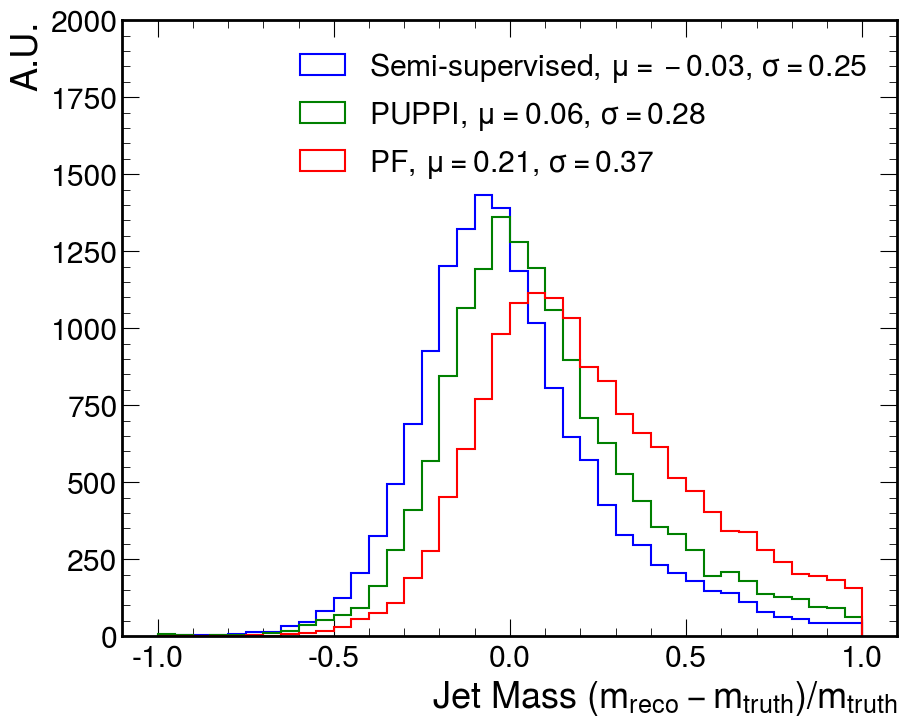

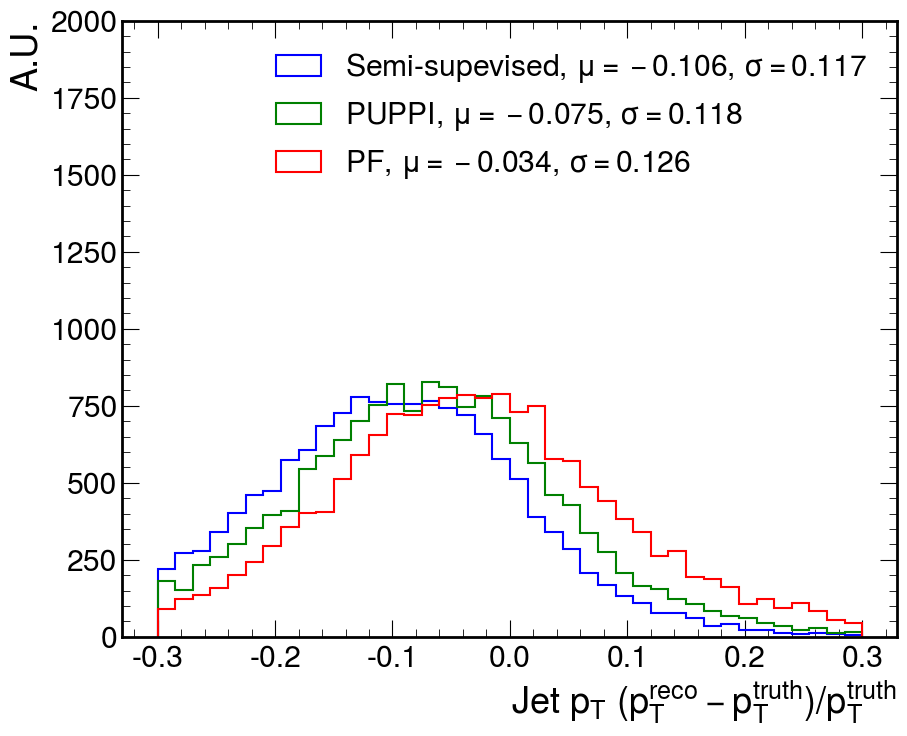

<Figure size 1000x1000 with 0 Axes>

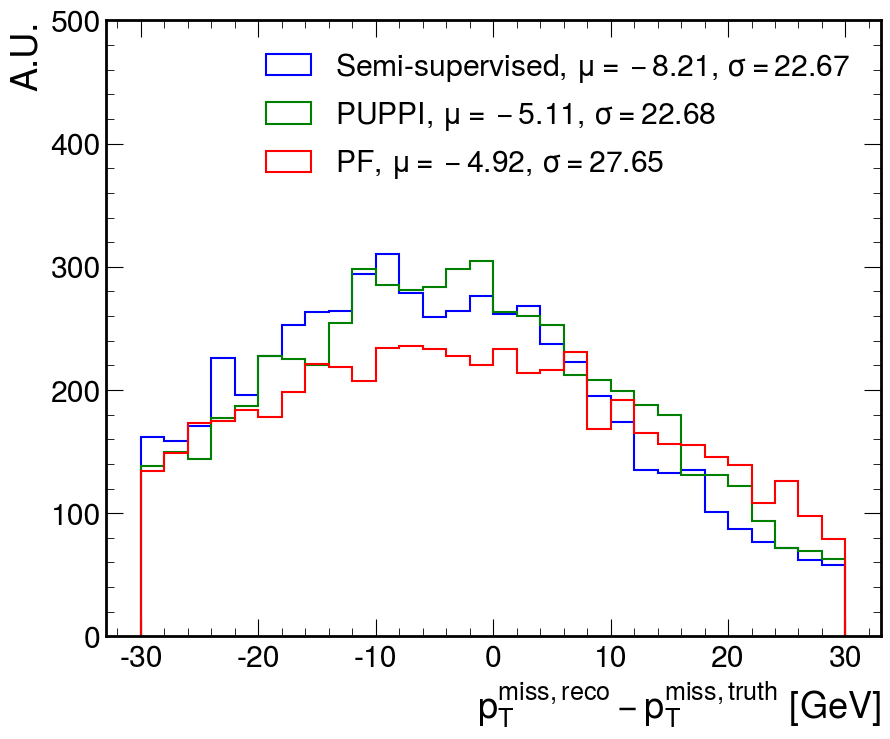

<Figure size 1000x1000 with 0 Axes>

In [17]:
def getResol(input):
    return (np.quantile(input, 0.84) - np.quantile(input, 0.16))/2

def getStat(input):
    return float(np.median(input)), float(getResol(input))

performances_jet_pred0 = performances_jet_pred['gated_boost']
#performances_jet_pred1 = performances_jet_pred['gated_noboost']
#performances_jet_pred2 = performances_jet_pred['graphsage_boost']
#performances_jet_pred3 = performances_jet_pred['graphsage_noboost']
#performances_jet_pred4 = performances_jet_pred['gated_boost_sp']


mets_pred0 = mets_pred['gated_boost']
#mets_pred1 = mets_pred['gated_noboost']
#mets_pred2 = mets_pred['graphsage_boost']
#mets_pred3 = mets_pred['graphsage_noboost']
#mets_pred4 = mets_pred['gated_boost_sp']

linewidth=1.5


%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_pred0])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='green', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi_wcut])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PF, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
#plt.xlim(-1.0,1.3)
plt.xlabel(r"Jet Mass $(m_{reco} - m_{truth})/m_{truth}$")
plt.ylabel('A.U.')
plt.ylim(0, 2000)
plt.legend()
plt.savefig("Jet_mass_diff.pdf")
plt.show()


#%matplotlib inline
fig = plt.figure(figsize=(10,8))

pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_pred0])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supevised, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_puppi])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='green', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_puppi_wcut])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PF, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
#plt.xlim(0,40)
plt.ylim(0, 2000)
plt.xlabel(r"Jet $p_{T}$ $(p^{reco}_{T} - p^{truth}_{T})/p^{truth}_{T}$")
plt.ylabel('A.U.')
plt.legend()
plt.show()
plt.savefig("Jet_pT_diff.pdf")


# MET resolution
#%matplotlib inline

fig = plt.figure(figsize=(10,8))
mets_diff = (np.array(mets_pred0) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
mets_diff = (np.array(mets_puppi) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='green', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
mets_diff = (np.array(mets_puppi_wcut) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PF, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))

plt.xlabel(r"$p^{miss, reco}_{T} - p^{miss, truth}_{T}$ [GeV]")
plt.ylabel('A.U.')
plt.ylim(0,500)
plt.legend()
plt.show()
plt.savefig("MET_diff.pdf")


## event image

In [18]:
ifile = "/Workdir/data_pickle/dataset_graph_puppi_8000"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)
data = DataLoader(dataset, batch_size=1)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
iters = iter(data)

eta_truths = np.array([])
phi_truths = np.array([])
charge_truths = np.array([])
pt_truths = np.array([])
pt_truth_scaled = np.array([])


## LV particles
eta_lvs = np.array([])
phi_lvs = np.array([])
charge_lvs = np.array([])

pt_lvs = np.array([])
pt_lv_scaled = np.array([])

pt_lv_puppi = np.array([])
pt_lv_puppi_scaled = np.array([])

pt_lv_pf = np.array([])
pt_lv_pf_scaled = np.array([])

pt_lv_pred = np.array([])
pt_lv_pred_scaled = np.array([])


njets = 0
model_gated_boost.to('cuda:0')
#odel_gated_boost_sp.to('cuda:0')

for i in range(1000):
    if i%1==0:
        print(f"finished {i}")
    res = iters.next()

    res_gpu = res.to(device)

    model_gated_boost.eval()
    pred_gpu = model_gated_boost.forward(res_gpu)
    pred = np.array(pred_gpu[0][:,0].cpu().detach())
    
    #a = np.vstack(pred)
    #dt = xgb.DMatrix(np.vstack(a))
    #pred_post = xgbmodel_load.predict(dt)
    
    #model_gated_boost_sp.eval()
    #predsl_gpu = model_gated_boost_sp.forward(res_gpu)
    #predsl = np.array(predsl_gpu[0][:,0].cpu().detach())

    pt  = np.array(res.x[:,2].cpu().detach())
    eta = np.array(res.x[:,0].cpu().detach())
    phi = np.array(res.x[:,1].cpu().detach())

    #uppi = np.array(res.x[:,res.num_feature_actual[0].item()-1].cpu().detach())
    puppi = np.array(res.pWeight.cpu().detach())
    #print("puppi weights", puppi)
    #print(puppi.shape)
    
    pt_truth = np.array(res.GenPart_nump[:,2].cpu().detach())
    eta_truth = np.array(res.GenPart_nump[:,0].cpu().detach())
    phi_truth = np.array(res.GenPart_nump[:,1].cpu().detach())
    charge_truth = np.array(res.GenPart_nump[:,4].cpu().detach())
    
    charge_index = res.Charge_index[0]
    charge = np.zeros(pt.shape[0])
    charge[charge_index] = 1

    jets_pred  = clusterJets(pt_truth, eta_truth, phi_truth)
    if len(jets_pred) == 0:
        continue
    njets += 1
    jet1st_pt  = jets_pred[0].pt
    jet1st_eta = jets_pred[0].eta
    jet1st_phi = jets_pred[0].phi 
    
    print("pt, eta, phi", jet1st_pt, jet1st_eta, jet1st_phi)

    #selection = (abs(eta-jet1st_eta) < 0.3 ) & (abs(deltaPhi(phi-jet1st_phi))<0.3)
    selection = np.ones(eta_truth.shape[0], dtype=bool)
    eta_truths = np.hstack([eta_truths, (eta_truth-jet1st_eta)[selection]])
    phi_truths = np.hstack([phi_truths, (phi_truth-jet1st_phi)[selection]])
    charge_truths = np.hstack([charge_truths, charge_truth[selection]])
    pt_truth_scaled = np.hstack([pt_truth_scaled, pt_truth[selection] / jet1st_pt])
    
    # LV after puppi, ssl-gnn
    #election_lv = (selection & (truth==1) & (charge==0))
    selection_lv = np.ones(eta.shape[0], dtype=bool)
    eta_lvs = np.hstack([eta_lvs, (eta-jet1st_eta)[selection_lv]])
    phi_lvs = np.hstack([phi_lvs, deltaPhiNew(phi-jet1st_phi)[selection_lv]])

    pt_lvs = np.hstack([pt_lvs, pt[selection_lv]])
    pt_lv_scaled = np.hstack([pt_lv_scaled, (pt/jet1st_pt)[selection_lv]])
    
    pt_lv_puppi = np.hstack([pt_lv_puppi, (pt*puppi)[selection_lv]])
    pt_lv_puppi_scaled = np.hstack([pt_lv_puppi_scaled, (pt*puppi)[selection_lv]/jet1st_pt])
    
    pt_lv_pred = np.hstack([pt_lv_pred, (pt*pred)[selection_lv]])
    pt_lv_pred_scaled = np.hstack([pt_lv_pred_scaled, (pt*pred)[selection_lv]/jet1st_pt])

    
pt_lv_puppi_scaled[pt_lv_puppi<0.]=0
pt_lv_puppi[pt_lv_puppi<0.]=0

finished 0
pt, eta, phi 199.4605247754565 0.407225283448491 -1.3640574782877097
finished 1
pt, eta, phi 93.94058759546894 -2.055485179974493 -2.923132286752046
finished 2
pt, eta, phi 91.31751684561178 1.0150826775302852 1.6257653789449436
finished 3
pt, eta, phi 208.3470282186869 1.3290847884473136 -1.9093364884934356
finished 4
pt, eta, phi 80.36642625495338 2.484447427562336 0.4746048984905825
finished 5
pt, eta, phi 99.42681986731102 0.17720467710212506 1.4153546425332542
finished 6
pt, eta, phi 91.09603905003772 0.9697385179319153 -1.1789354424770515
finished 7
pt, eta, phi 127.59893263327066 0.19903363467143695 0.34758752307969487
finished 8
pt, eta, phi 145.02788140348716 0.45234489736242095 1.0926292533210955
finished 9
pt, eta, phi 289.68810172266495 0.9112687617902252 0.5868416660197248
finished 10
pt, eta, phi 132.91824483710053 -0.49477917954460576 -1.6509153231418878
finished 11
pt, eta, phi 84.55133623965952 -2.2149865829139377 -0.0950747010355002
finished 12
pt, eta, phi

pt, eta, phi 138.32154190714942 1.085418062711424 0.6763817528110244
finished 133
pt, eta, phi 133.1795662513444 0.851056064660678 -2.017299061601201
finished 134
pt, eta, phi 82.86074101600353 1.831891828679969 -0.6458791309854721
finished 135
pt, eta, phi 77.8912019988684 -2.610500323664963 -1.9753954904521924
finished 136
pt, eta, phi 160.78474420205816 -0.318248200372531 0.3462215261647311
finished 137
pt, eta, phi 75.3000972678385 -0.7535972373375539 2.696134120396716
finished 138
pt, eta, phi 74.05319056020655 2.1997464964295452 -2.139885391056481
finished 139
pt, eta, phi 85.77621827351274 0.6082508826664954 -0.22314060166204985
finished 140
pt, eta, phi 101.78246939085153 0.4586916565308471 0.5729279941717857
finished 141
pt, eta, phi 79.77953781498304 -2.364794957014666 0.9295075877913203
finished 142
pt, eta, phi 263.9671678099637 -1.377962500399273 -0.24565452883276961
finished 143
pt, eta, phi 101.21577489569955 -2.4409677044520244 -2.5979684257101177
finished 144
pt, eta, 

finished 231
pt, eta, phi 116.20540954085035 -0.21274761992157037 0.719130747239712
finished 232
pt, eta, phi 188.05737582933057 -1.8598360097361468 -1.5604936719350224
finished 233
pt, eta, phi 117.04804913019353 0.3897745992688526 -1.165173559692625
finished 234
pt, eta, phi 125.78273823953175 -0.48614285441908595 -0.6193073714790271
finished 235
pt, eta, phi 117.93357070727185 -0.5963679540595664 -1.0596057529404872
finished 236
pt, eta, phi 160.49441787575373 -0.7890476859063756 0.6676843232670265
finished 237
pt, eta, phi 104.88822845288975 2.1379000340870076 1.0041879587830957
finished 238
pt, eta, phi 72.09734322199104 -1.533447717513024 -0.9171505677559288
finished 239
pt, eta, phi 230.89581070712208 -1.9134898569469567 1.3222480883935912
finished 240
pt, eta, phi 81.93555140269467 -2.9689603494446692 0.8305045759963506
finished 241
pt, eta, phi 214.0870588643539 1.20456032703427 1.6677255460632783
finished 242
pt, eta, phi 61.81163390533014 0.7333926605568034 -0.98227074168935

finished 344
pt, eta, phi 115.9856946074783 2.4004347629552596 -0.1200248008892002
finished 345
pt, eta, phi 99.77274654017936 -1.038970245951221 -0.9968311448556229
finished 346
pt, eta, phi 168.92653628853878 -1.931940225848313 0.7009260940221073
finished 347
pt, eta, phi 109.71854552596479 2.16102560932459 -1.0258982028639831
finished 348
pt, eta, phi 121.48729073284423 0.05186928891639978 2.2984212142281635
finished 349
pt, eta, phi 119.5142914601643 -0.9542647576707349 -0.8708440379627289
finished 350
pt, eta, phi 208.42462265990972 0.3550029784651113 -0.8349229272635528
finished 351
pt, eta, phi 166.77084600570575 -2.611406813997394 1.192114786815123
finished 352
pt, eta, phi 142.83934918964434 0.2498287748270079 -2.2841936119349433
finished 353
pt, eta, phi 202.3027523524767 -0.12737015359388562 -1.7806352053032652
finished 354
pt, eta, phi 115.19814539622877 -0.820152714743364 -1.0801656028223228
finished 355
pt, eta, phi 229.99121878346216 -1.5744698628532803 0.881023381784975

finished 468
pt, eta, phi 138.92865480632548 0.34747332255964486 0.501095635942457
finished 469
pt, eta, phi 152.3678298518834 1.0366668388970095 -2.0775108317335054
finished 470
pt, eta, phi 83.92313153711575 -0.6995631588254996 -0.5772021935471212
finished 471
pt, eta, phi 83.10688571602827 2.1856819270147065 -0.7212812389720371
finished 472
pt, eta, phi 100.09803132199809 -2.2386769681738072 -0.275961100496219
finished 473
pt, eta, phi 158.61368879439254 -1.8357270111125152 0.33234934183620507
finished 474
pt, eta, phi 104.32124055210541 -0.9692586754486889 -2.931976994883841
finished 475
pt, eta, phi 180.5348898197393 -0.17545059481903783 -0.8410479629982133
finished 476
pt, eta, phi 170.4221076441089 -0.5157582838692334 2.788547454026658
finished 477
pt, eta, phi 178.221308085416 1.205804813972361 -1.8618158562621714
finished 478
pt, eta, phi 157.19565934463895 -0.2696499446969998 -1.5648196551621076
finished 479
pt, eta, phi 108.0306645204502 -0.7220036034496935 -0.66155342214734

pt, eta, phi 108.83291997983626 -1.1267681840266075 -1.4116640041189772
finished 580
pt, eta, phi 158.67360563935722 -0.17606440766696707 1.0930326582097682
finished 581
pt, eta, phi 171.28275041617826 -1.5502966085705936 -0.7506696230012606
finished 582
pt, eta, phi 96.94759422395322 -0.1273452563997441 -2.156151106291576
finished 583
pt, eta, phi 69.2367284284895 -1.68134267436602 -2.0545261821272396
finished 584
pt, eta, phi 182.0357485629628 -1.0555483523484692 -0.5013613457046091
finished 585
pt, eta, phi 141.50309546227464 1.8022917706891552 2.6957067467553366
finished 586
pt, eta, phi 91.57976086329728 1.7641708035721555 1.492570029431362
finished 587
pt, eta, phi 90.81055167561615 -0.2608063679735372 -1.2028421626043668
finished 588
pt, eta, phi 150.8696641474971 -2.621904294543924 -2.412099141650973
finished 589
pt, eta, phi 102.26372366708878 -0.7874667997519126 -3.0927763761242386
finished 590
pt, eta, phi 127.57468303730695 -0.9692815109613135 -1.7071915795725268
finished 5

pt, eta, phi 89.45143322334317 0.9724774533721261 2.583974809650435
finished 680
pt, eta, phi 75.0435296472106 -1.6350243933966044 1.4628132423237534
finished 681
pt, eta, phi 147.3326084232667 0.07309845403205278 1.363612929891379
finished 682
pt, eta, phi 106.95511159777197 0.007450957444931607 -3.0204090383565543
finished 683
pt, eta, phi 171.97340598417037 0.3787444844906431 -1.0208758840741705
finished 684
pt, eta, phi 135.99129333355623 -3.128318022491778 2.6874232655341985
finished 685
pt, eta, phi 144.02969748840508 0.23425267070852684 -1.1328875826063038
finished 686
pt, eta, phi 106.07584451686935 1.5792668328416404 -1.945332264286697
finished 687
pt, eta, phi 90.47833412787999 0.197151888908878 -1.416444062493956
finished 688
pt, eta, phi 72.96219229512208 1.7090998772052322 -0.9436041620029343
finished 689
pt, eta, phi 120.03893581296843 -2.1286418731898897 0.21170117198155383
finished 690
pt, eta, phi 162.91045865357634 -0.961445009371058 0.6915466240350823
finished 691
pt

finished 796
pt, eta, phi 131.02990892888198 0.9166562232590192 2.56570240406187
finished 797
pt, eta, phi 129.94325473067894 -0.27703644709174563 -2.798983267785406
finished 798
pt, eta, phi 82.2786069432216 -3.4616796066011672 1.04711404903588
finished 799
pt, eta, phi 120.69750995763839 0.6317108932555472 2.217809365373176
finished 800
pt, eta, phi 123.94144088288174 -2.2561372720187487 -1.599597284603333
finished 801
pt, eta, phi 92.95883618888783 -2.4383811917344134 -1.8221276451666233
finished 802
pt, eta, phi 103.56304646360681 -2.1344206704096615 -2.7690064528619867
finished 803
pt, eta, phi 144.4790538000658 0.39303497607312593 -0.7463026964022621
finished 804
pt, eta, phi 69.871791619853 -0.9041335621386597 2.070263271388312
finished 805
pt, eta, phi 177.39032633050246 -0.25974628176982484 -1.7272727842499433
finished 806
pt, eta, phi 135.07302367061047 0.397917166298494 2.3717834189230693
finished 807
pt, eta, phi 208.51055138207528 0.7419763684162899 -0.32758758464334203
fi

finished 904
pt, eta, phi 183.31074023958618 -1.2858615828798863 -0.673396257951528
finished 905
pt, eta, phi 101.62222739224278 1.4571934916505684 1.19531555330516
finished 906
pt, eta, phi 112.64049024134228 -2.555411271256695 -1.629953419879568
finished 907
pt, eta, phi 95.56578501427143 -0.621743884346301 -3.0215230140812297
finished 908
pt, eta, phi 113.8118673065006 -1.503088855008117 -0.6325502462357129
finished 909
pt, eta, phi 70.9832839543532 1.2267794697759749 2.9338195317910727
finished 910
pt, eta, phi 146.4334523533583 1.864080078991469 -1.2992963717197856
finished 911
pt, eta, phi 91.15251720803036 -3.323672294729903 -0.7198889070217538
finished 912
pt, eta, phi 178.77156865201977 0.7547796929445598 2.5146479379788365
finished 913
pt, eta, phi 61.88467669822787 1.272250115276539 -1.3372085957489688
finished 914
pt, eta, phi 98.44432471803103 -1.7729372065851565 1.9969658145967162
finished 915
pt, eta, phi 92.93419561275617 -3.007620722312969 2.7905528773599215
finished 9

In [153]:
print(pt_lv_scaled)
np.where(pt_lv_puppi_scaled!=0)

[0.00406537 0.00438321 0.0042477  ... 0.00212336 0.01349796 0.00864093]


(array([    9,    10,    11, ..., 39778, 39789, 39801]),)

In [154]:
pt_lv_puppi_scaled[9]

0.002455363282933831

## LV particles

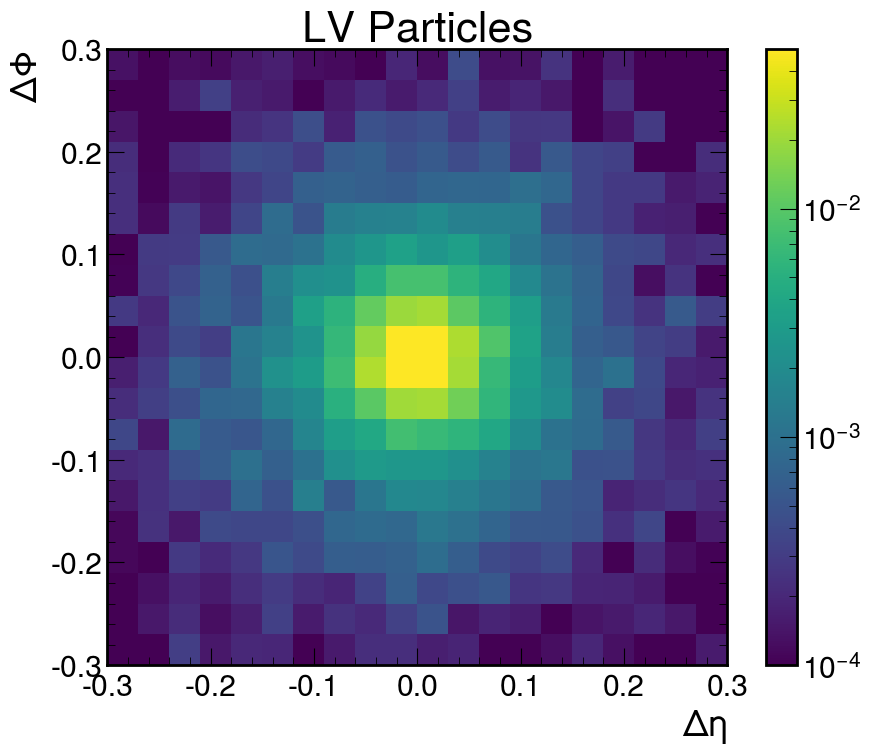

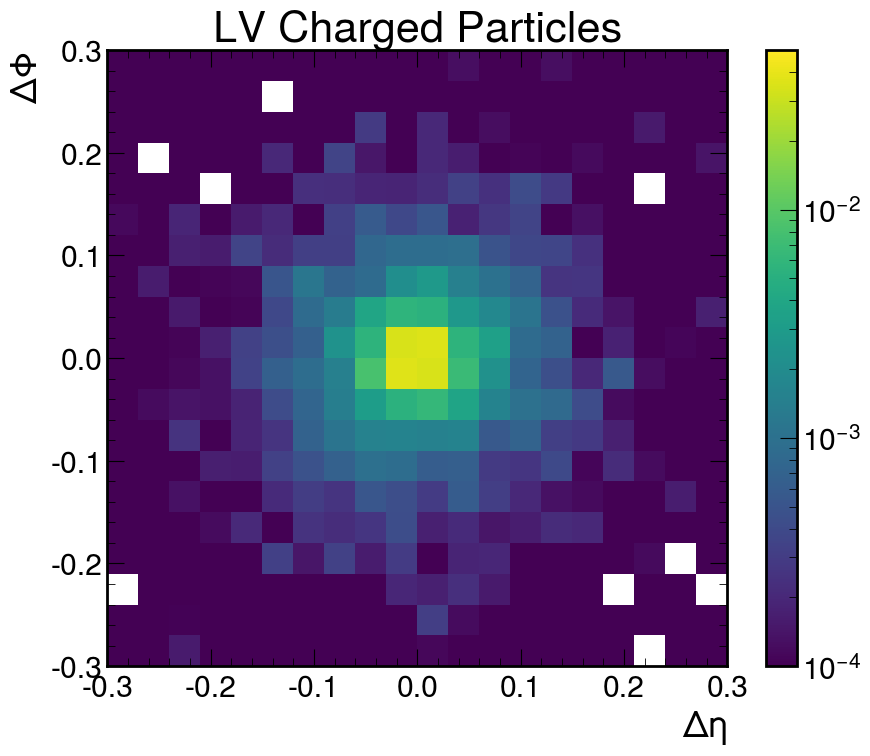

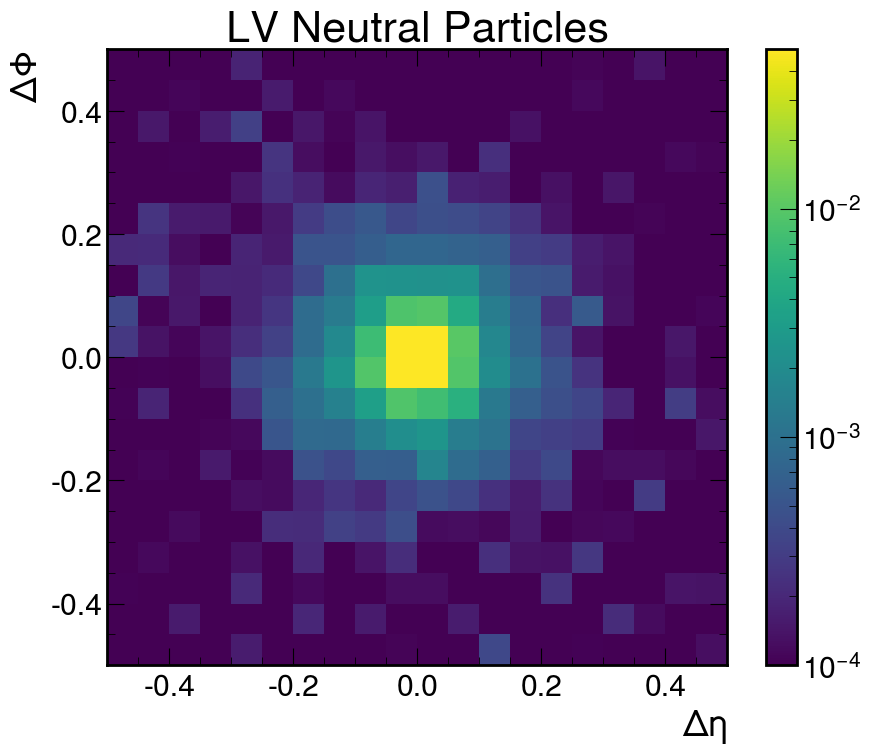

In [20]:
%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths, phi_truths, bins=20, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_truth_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths[charge_truths==1], phi_truths[charge_truths==1], bins=20, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_truth_scaled[charge_truths==1]/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Charged Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths[charge_truths==0], phi_truths[charge_truths==0], bins=20, range=[[-0.5,0.5],[-0.5,0.5]], weights=pt_truth_scaled[charge_truths==0]/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Neutral Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

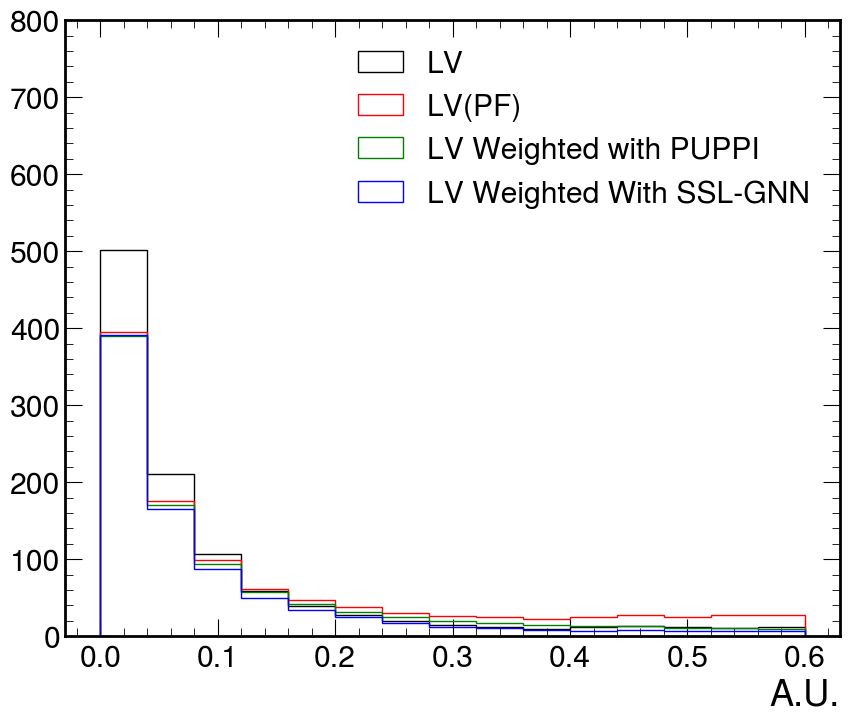

<Figure size 1000x800 with 0 Axes>

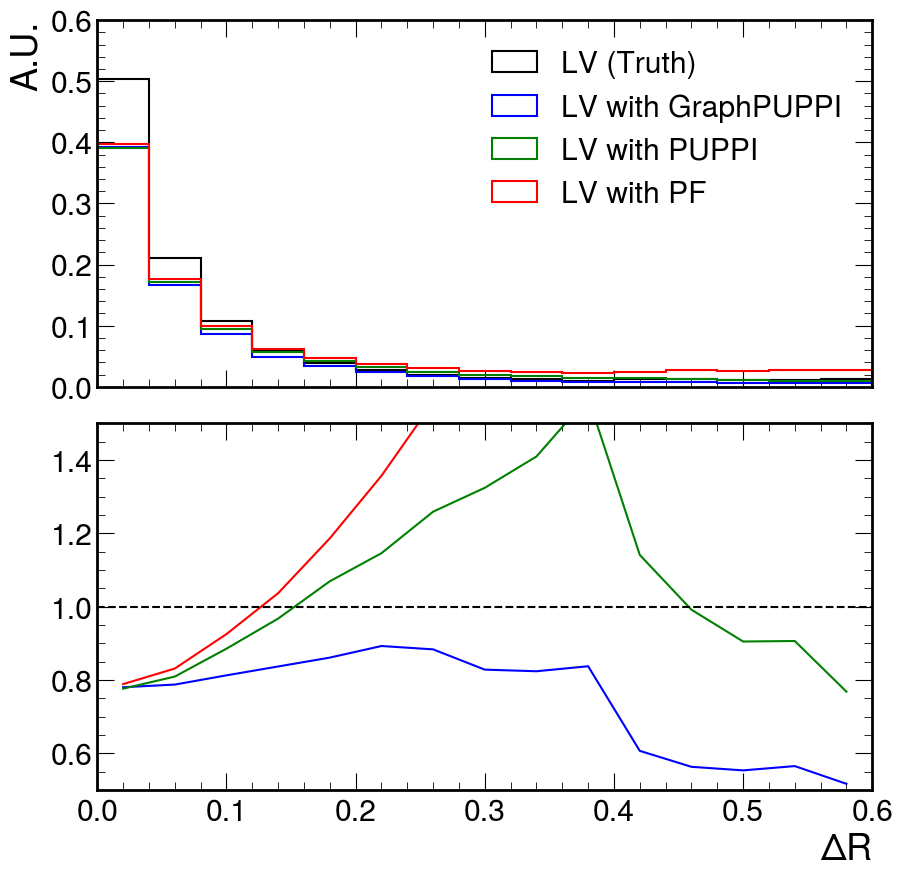

In [21]:
dR_truth = deltaRNew(eta_truths, phi_truths)
dR_lv    = deltaRNew(eta_lvs, phi_lvs)

%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
#plt.hist(dR_truth, bins=20, range=(0,0.45), histtype='step', color='black', linestyle='-.', label=r'LV', density=True)
plt.hist(dR_truth, bins=15, range=(0,0.6),histtype='step', color='black', linestyle='-', weights=pt_truth_scaled, label=r'LV', density=False)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', label=r'LV(PF)', weights= pt_lv_scaled, density = False)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='g', linestyle='-',   weights = pt_lv_puppi_scaled, label=r'LV Weighted with PUPPI', density=False)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='b',linestyle='-', weights = pt_lv_pred_scaled,  label=r'LV Weighted With SSL-GNN', density=False)
ax.set_xlabel(r"$\Delta R$")
ax.set_xlabel('A.U.')
ax.set_ylim(0,800)
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios': [1,1]})
fig.subplots_adjust(hspace=0.1)
vals, bins, _ = ax1.hist(dR_truth,bins=15,range=(0,0.6),histtype='step', color='black', linestyle='-',  linewidth=1.5, weights = pt_truth_scaled / njets, label = r'LV (Truth)', density=False)
vals_pred, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='blue', linestyle='-', linewidth=1.5, weights = pt_lv_pred_scaled/njets,  label=r'LV with GraphPUPPI', density=False)
vals_puppi, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='g', linestyle='-', linewidth=1.5, weights = pt_lv_puppi_scaled/njets, label=r'LV with PUPPI', density=False)
vals_pf, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', linewidth=1.5, weights = pt_lv_scaled/njets, label=r'LV with PF',density=False)
ax1.set_ylabel('A.U.')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,0.6)
ax1.legend()
#plt.ylim(0,0.025)
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pred/vals, color='blue')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_puppi/vals, color='g')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pf/vals, color='r')
ax2.set_xlim(0,0.6)
ax2.set_xlabel(r"$\Delta R$")
ax2.set_ylim(0.5,1.5)
ax2.axhline(y=1.0, color='black', linestyle='dashed')
plt.show()

Truth LV sum:  0.8839110990294095
PUPPI PU sum:  0.8385730629857632
SSL-GNN sum:  0.7874983927322778


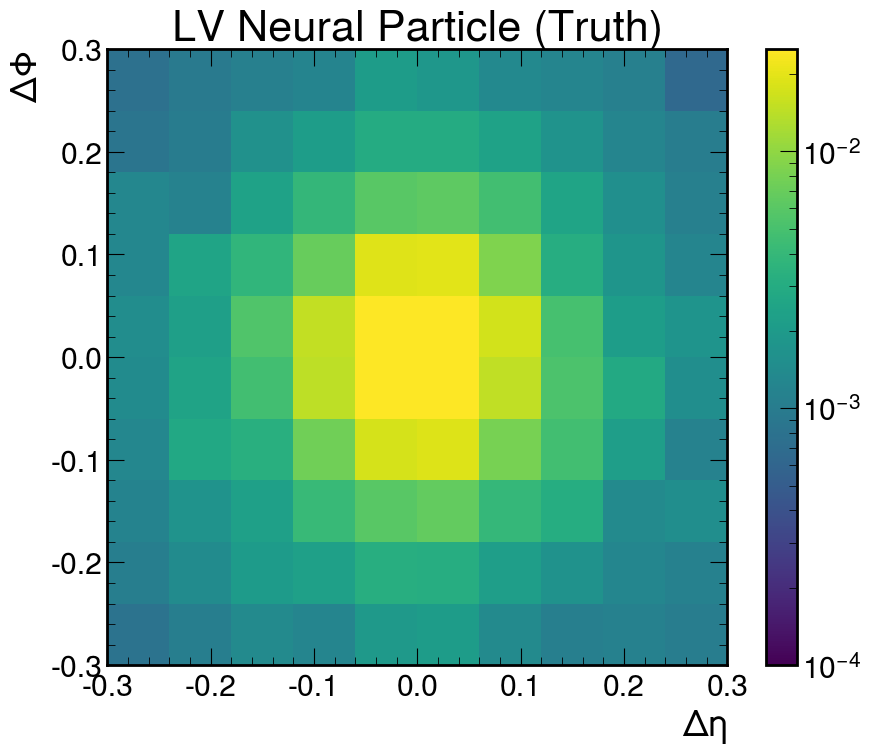

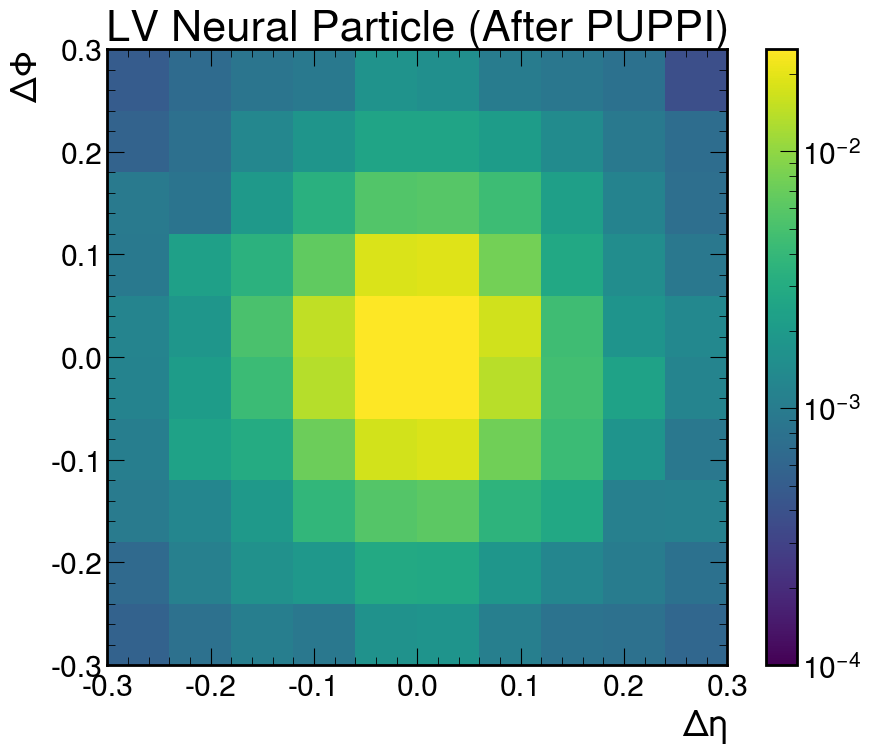

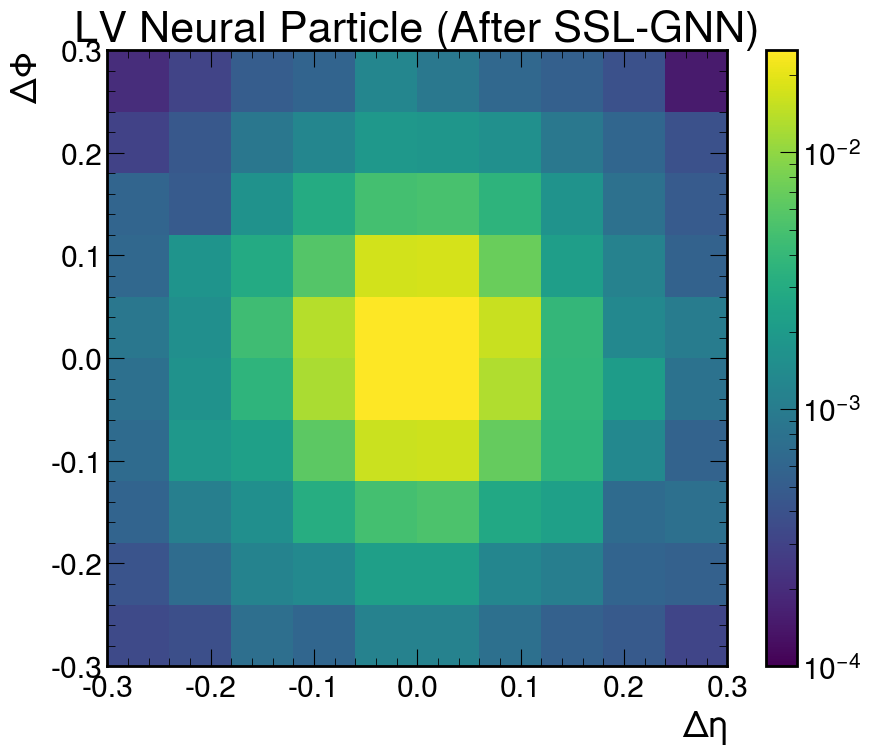

In [22]:
#
#2d plots
#
fig = plt.figure(figsize=(10,8))
results_lv = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_lv[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (Truth)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("Truth LV sum: ", np.sum(results_lv[0]))

fig = plt.figure(figsize=(10,8))
results_puppi = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_puppi_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_puppi[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After PUPPI)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("PUPPI PU sum: ", np.sum(results_puppi[0]))

fig = plt.figure(figsize=(10,8))
results_pred = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_pred_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_pred[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After SSL-GNN)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("SSL-GNN sum: ", np.sum(results_pred[0]))